In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=e415c504cf41bcb8d7595606048d3120694c87a610c16bf9c7e08ab8ea9984c8
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia


# Задание 1


Выберите 5 языков в википедии (не тех, что использовались в семинаре). Скачайте по 10 случайных статей для каждого языка. Предобработайте тексты, удаляя лишние теги/отступы/разделители (если они есть). Разделите тексты на предложения и создайте датасет, в котором каждому предложению соответствует язык. Кластеризуйте тексты, используя эмбединг модель из прошлого семинара и любой алгоритм кластеризации. Проверьте качество кластеризации с помощь метрики ARI. Отдельно проанализируйте 3 ошибочно кластеризованных текста (если такие есть).

## Импорты + функции + датасет

In [ ]:
import re
import wikipedia
import numpy as np
from torch.utils.data import Dataset
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sentence_transformers import SentenceTransformer
from typing import Dict, List, Optional
from tqdm import tqdm

In [ ]:
code2lang = wikipedia.languages()

In [ ]:
def load_with_disambigution(page):
    try:
        p = wikipedia.page(page)
    except wikipedia.DisambiguationError as e:
        random_option = np.random.choice(e.options)
        p = wikipedia.page(random_option)
    return p

In [ ]:
def preprocess_data(text: str) -> list:
    text = re.sub(r'\w*@\w*\.\w*', '', text, flags=re.UNICODE)
    text = re.sub(r'(?:\(.*\)|\{.*\}|\[.*\])', '', text) # убрать все вставки в скобках, так как часто встречаются лишнее
    text = re.sub(r'\d+', '', text) # убрать числа
    text = re.sub(r'[\t,\-\–\—\:\;|?\!\«»"\/\\]+', '', text) # пунктуация
    text = re.sub(r'\.', '\n', text) # заменить точки на перенос строк, чтобы потом сплитить
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'\b[А-я]{1}\b', '\n', text)
    text = re.sub(r' {2,}', ' ', text)

    sentensized_text = []
    for sent in text.split('\n'):
        sent = re.sub(r'(?:^ |\n{2,}| {2,})+', '', sent)
        sent = re.sub(r'(?:^ | $)', '', sent)
        sent = sent.lower()
        if sent and re.match('.{3,}', sent):
          sentensized_text.append(sent)

    return sentensized_text

In [ ]:
def get_content(pages):
    new_content = []
    for page_name in pages:
        try:
            page = load_with_disambigution(page_name)
        except Exception as e:
            continue
        text = f'{page.title}\n{page.content.replace("==", "")}'
        array = preprocess_data(text)
        return array
        new_content.extend(array)
    return new_content

In [ ]:
def downoad_article(lang, n=10, percent=10, words=800):
    quantile = words * 10 / 100
    max_words = words + quantile
    min_words = words - quantile
    wikipedia.set_lang(lang)
    wiki_content = []

    pages = wikipedia.random(n)
    wiki_content.extend(get_content(pages))
    words = sum([len([word for word in wiki_content[num].split()]) for num in range(len(wiki_content))])
    # необходимо, чтобы количество слов для каждого языка было примерно одинаковое
    while words < min_words and words < max_words:
        pages = [wikipedia.random()]
        wiki_content.extend(get_content(pages))
        words = sum([len([word for word in wiki_content[num].split()]) for num in range(len(wiki_content))])
    print(f'{lang}: слов {words}')

    return wiki_content, words

In [ ]:
class MultilingualDataset(Dataset):
    def __init__(self, data: Dict[str, List[str]], model_name: str = MODEL_NAME):
        self.model = SentenceTransformer(model_name)
        self.langs = []
        self.texts = []

        for lang, sentences in data.items():
            for s in sentences:
                self.langs.append(lang)
                self.texts.append(s)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        lang = self.langs[idx]
        emb = self.model.encode(text, convert_to_numpy=True)
        return {"language": lang, "sentence": text, "embedding": emb}

    def get_embeddings(self, lang, batch_size: int = 16):
        all_embeddings = []
        plain_texts = []
        texts = [t for l, t in zip(self.langs, self.texts) if l == lang]
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i + batch_size]
            batch_embs = self.model.encode(batch, convert_to_numpy=True)
            all_embeddings.append(batch_embs)
            plain_texts.extend(batch)
        return np.vstack(all_embeddings), plain_texts


## Попытка решить задачу с малыми языками (спойлер: с ужасным качеством, можно не смотреть)

In [ ]:
selected_langs = ['mrj', 'kv', 'kbd', 'xal', 'myv']

In [ ]:
print('\n'.join([f'код: {lang}, {code2lang[lang]}' for lang  in selected_langs]))

код: mrj, кырык мары
код: kv, коми
код: kbd, адыгэбзэ
код: xal, хальмг
код: myv, эрзянь


Кырык мары = Горномарийский (марийский < финно-пермские < финно-угорские < уральские)

Коми (пермские < финно-угорские < уральские)

Эрзянь = эрзянский (мордовские < финно-волжские < финно-пермская < финно-угорские < уральские)

Хальмг = калмыцкий (западномонгольские < северомонгольские < монгольские)

Адыгэбзэ = кабардино-черкесский язык (адыгские < абхазо-адыгские)

In [ ]:
MODEL_NAME = 'sentence-transformers/distiluse-base-multilingual-cased-v2'

In [ ]:
wikipedia.set_lang('mrj')

In [ ]:
wiki_texts = {}

for lang in selected_langs:
    try:
        wiki_texts[lang] = downoad_article(lang, 10)
    except Exception as e:
        print('ERROR ON - ', lang, str(e).strip('\n'))
        continue

mrj: слов 727
kv: слов 720
kbd: слов 769
xal: слов 894
myv: слов 753


### sentence-transformers/distiluse-base-multilingual-cased-v2

In [ ]:
dataset = MultilingualDataset(wiki_texts)

In [ ]:
embedded_langs = {}
for lang in selected_langs:
    embedded_langs[lang], _ = dataset.get_embeddings(lang, 32)

100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


In [ ]:
texts = []
true_labels = []
for label, x in embedded_langs.items():
    true_labels.extend([label]*len(x))
    texts.extend(x)
len(texts)
len(true_labels)

1005

In [ ]:
import random
random.random_state = 25
c = list(zip(texts, true_labels))
random.shuffle(c)
texts, true_labels = zip(*c)

In [ ]:
texts_lengths = sum([len(x) for x in embedded_langs.values()])
X = np.zeros((texts_lengths, 512))
cluster = KMeans(n_clusters=5)
for i, text in enumerate(texts):
    X[i] = text

In [ ]:
X.shape

(1005, 512)

In [ ]:
cluster = KMeans(5, random_state=25)
cluster.fit(X)
labels = np.array(cluster.labels_)+1

In [ ]:
labels

array([2, 2, 1, ..., 3, 2, 2], dtype=int32)

In [ ]:
ARI = adjusted_rand_score(true_labels, labels)
ARI

0.05214757391939756

### sentence-transformers/all-mpnet-base-v2

In [ ]:
dataset = MultilingualDataset(wiki_texts, 'sentence-transformers/all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
embedded_langs = {}
for lang in selected_langs:
    embedded_langs[lang], _ = dataset.get_embeddings(lang, 16)

100%|██████████| 19/19 [00:52<00:00,  2.78s/it]


In [ ]:
texts = []
true_labels = []
for label, x in embedded_langs.items():
    true_labels.extend([label]*len(x))
    texts.extend(x)

In [ ]:
random.random_state = 25
c = list(zip(texts, true_labels))
random.shuffle(c)
texts, true_labels = zip(*c)

In [ ]:
texts_lengths = sum([len(x) for x in embedded_langs.values()])
X = np.zeros((texts_lengths, 512))
cluster = KMeans(n_clusters=5)
for i, text in enumerate(texts):
    X[i] = text

In [ ]:
cluster = KMeans(5, random_state=25)
cluster.fit(X)
labels = np.array(cluster.labels_)+1

In [ ]:
ARI = adjusted_rand_score(true_labels, labels)
ARI

0.05898334148180879

## Более популярные языки (и относительно нормальное качество)

In [ ]:
code2lang = wikipedia.languages()

sah – якутский

sk – словакий

sco – шотландский

pt – португальский

mt – мальтийский


In [ ]:
selected_langs = ['pt', 'sah', 'sco', 'sk', 'mt']

In [ ]:
wiki_texts = {}


max_words = 800
for lang in selected_langs:
    try:
        wiki_texts[lang], words = downoad_article(lang, 10, max_words)
        if max_words - words < -100:
            max_words = words
    except Exception as e:
        print('ERROR ON - ', lang, str(e).strip('\n'))
        continue

pt: слов 866
sah: слов 941
sco: слов 730
sk: слов 770
mt: слов 770


In [ ]:
wiki_texts['pt'][1]

'positivo tecnologia é uma empresa brasileira de tecnologia sediada em curitiba paraná que desenvolve fabrica e comercializa computadores celulares tablets dispositivos de casa e escritório inteligente servidores infraestrutura de ti máquinas de pagamento e tecnologias educacionais'

Эмбеддер: sentence-transformers/all-mpnet-base-v2

In [ ]:
dataset = MultilingualDataset(wiki_texts, 'sentence-transformers/all-mpnet-base-v2')

In [ ]:
embedded_langs = {}
plain_texts = []
for lang in selected_langs:
    embedded_langs[lang], texts = dataset.get_embeddings(lang, 16)
    plain_texts.extend(texts)

100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


In [ ]:
len(plain_texts)

402

In [ ]:
embeddings = []
true_labels = []
for label, x in embedded_langs.items():
    true_labels.extend([label]*len(x))
    embeddings.extend(x)

In [ ]:
random.random_state = 25
c = list(zip(embeddings, true_labels, plain_texts))
random.shuffle(c)
embeddings, true_labels, plain_texts = zip(*c)

In [ ]:
texts_lengths = sum([len(x) for x in embedded_langs.values()])
X = np.zeros((texts_lengths, 768))
cluster = KMeans(n_clusters=5)
for i, text in enumerate(embeddings):
    X[i] = text

In [ ]:
cluster = KMeans(5, random_state=25)
cluster.fit(X)
labels = np.array(cluster.labels_)

In [ ]:
ARI = adjusted_rand_score(true_labels, labels)
ARI

0.5721314204934758

In [ ]:
lang2id = {value: num for num, value in enumerate(selected_langs)}
id2lang = {num: value for num, value in enumerate(selected_langs)}

In [ ]:
y_true = [lang2id[l] for l in true_labels]

Для сопоставления лейблов (для анализа ошибок) я использую Hungarian algorithm в имплементации scipy https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html

In [ ]:
Counter(cluster.labels_)

Counter({np.int32(4): 24,
         np.int32(0): 106,
         np.int32(1): 106,
         np.int32(3): 108,
         np.int32(2): 58})

In [ ]:
Counter(y_true)

Counter({3: 119, 1: 110, 2: 55, 4: 59, 0: 59})

In [ ]:
true_names = {'sah': 'якутский',
              'sk': 'словацкий',
              'sco': 'шотландский',
              'pt': 'португальский',
              'mt': 'мальтийский'}

In [ ]:
cm = confusion_matrix(y_true, labels)

# Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(-cm)
mapping = {col: row for row, col in zip(row_ind, col_ind)}

y_pred_aligned = np.array([mapping.get(c, c) for c in labels])

mistake_indices = np.where(y_pred_aligned != y_true)[0]

for num, idx in enumerate(mistake_indices[:5]):
    true_label = y_true[idx]
    pred_label = y_pred_aligned[idx]

    true_lang = id2lang.get(true_label, f"unknown_{true_label}")
    pred_lang = id2lang.get(int(pred_label), f"cluster_{int(pred_label)}")

    print(f'Text #{num+1}')
    print("Sentence:", plain_texts[idx])
    print("True label:", true_names[true_lang])
    print("Predicted cluster:", true_names[pred_lang])
    print("---" * 25)


Text #1
Sentence: mike nichols v československej filmovej databáze
True label: словацкий
Predicted cluster: мальтийский
---------------------------------------------------------------------------
Text #2
Sentence: zselickisfalud
True label: словацкий
Predicted cluster: шотландский
---------------------------------------------------------------------------
Text #3
Sentence: commons ponúka multimediálne súbory na tému ludwigsburg
True label: словацкий
Predicted cluster: мальтийский
---------------------------------------------------------------------------
Text #4
Sentence: the temple institute
True label: мальтийский
Predicted cluster: шотландский
---------------------------------------------------------------------------
Text #5
Sentence: e onor
True label: мальтийский
Predicted cluster: шотландский
---------------------------------------------------------------------------


Что касается четвертого текста, тут проблема скорее изначальной выборки, так как в текстах осталось много английского.

In [ ]:
lang2id

{'pt': 0, 'sah': 1, 'sco': 2, 'sk': 3, 'mt': 4}

In [ ]:
[lang2id.keys()]

[dict_keys(['pt', 'sah', 'sco', 'sk', 'mt'])]

In [ ]:
list(lang2id.keys())

['pt', 'sah', 'sco', 'sk', 'mt']

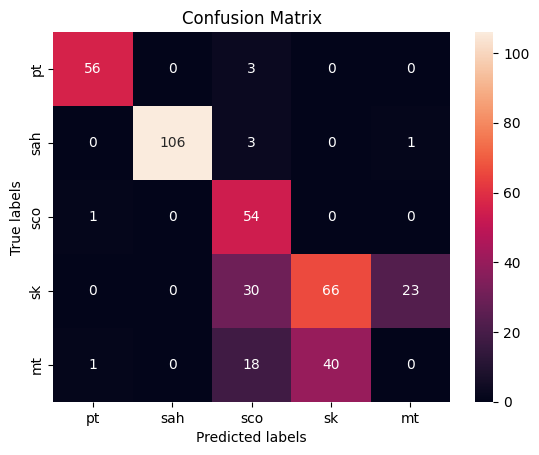

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


cm_2 = confusion_matrix(y_true, y_pred_aligned)
ax= plt.subplot()
sns.heatmap(cm_2, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(lang2id.keys())); ax.yaxis.set_ticklabels(list(lang2id.keys()));

Как видно, мальтийский вообще ни разу правильно не распознался, он путается с шотландским. Якутский распознается хорошо по довольно очевидным причинам (там алфавит на основе кириллице, а не латиницы). Португальский тоже очень хорошо, вероятно, из-за диакритиков.

# Задание 2

Загрузите корпус `annot.opcorpora.no_ambig_strict.xml.bz2` с OpenCorpora. Найдите в корпусе самые частотные морфологически омонимичные словоформы (те, которым соответствует разный грамматический разбор в разных предложениях). Также найдите словоформы с самых большим количеством вариантов грамматических разборов.

In [ ]:
!wget https://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig_strict.xml.bz2

--2025-10-12 12:21:27--  https://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig_strict.xml.bz2
Resolving opencorpora.org (opencorpora.org)... 172.67.163.210, 104.21.15.199, 2606:4700:3030::6815:fc7, ...
Connecting to opencorpora.org (opencorpora.org)|172.67.163.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1435452 (1.4M) [application/x-bzip2]
Saving to: ‘annot.opcorpora.no_ambig_strict.xml.bz2’

annot.opcorpora.no_ 100%[===================>]   1.37M  --.-KB/s    in 0.008s  

2025-10-12 12:21:28 (161 MB/s) - ‘annot.opcorpora.no_ambig_strict.xml.bz2’ saved [1435452/1435452]



In [ ]:
!pip install lxml -q

In [ ]:
import bz2
from lxml import etree
from collections import defaultdict, Counter

In [ ]:
with bz2.open('annot.opcorpora.no_ambig_strict.xml.bz2', 'rb') as f_in, open('annot.opcorpora.no_ambig_strict.xml', 'wb') as f_out:
    f_out.write(f_in.read())

In [ ]:
open_corpora = etree.fromstring(open('annot.opcorpora.no_ambig_strict.xml', 'rb').read())

In [ ]:
corpus = []


for sentence in open_corpora.xpath('//tokens'):
    sent_tagged = []
    for token in sentence.xpath('token'):
        word = token.xpath('@text')
        gram_info = token.xpath('tfr/v/l/g/@v')
        sent_tagged.append([word[0]] + gram_info)

    corpus.append(sent_tagged)

In [ ]:
analyses = defaultdict(list)

for sent in corpus:
    for word in sent:
        true_word = word[0].lower()
        gram_info = tuple(word[1:])
        analyses[true_word].append(gram_info)

In [ ]:
freq_counter = defaultdict(int)
most_homonyms = defaultdict(int)
for key, value in analyses.items():
    if len(set(value)) == 1:
        continue
    freq_counter[key] += len(value)
    most_homonyms[key] = len(set(value))

In [ ]:
print(' '*20 + 'Самые частотные (топ-20) омонимичные формы и их грамматические формы')
print('・'*65)
for word in sorted(freq_counter.items(), key=lambda x: -x[1])[:20]:
    # print(f'\t{word[0]} {"{:<10}".format('')} | {"{:<7}".format('')} {word[1]}')
    print(f'WORD: {"{:<70}".format(word[0])} ● TIMES ENCOUNTERED: {word[1]}')
    # print('・'*65)
    print()
    print('・'*28 + ' DEFINITIONS ' + '・'*29)
    print()
    print('\n'.join([' | '.join([y for y in x]) for x in set(analyses[word[0]])]))
    print()
    print('・'*65)

                    Самые частотные (топ-20) омонимичные формы и их грамматические формы
・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・
WORD: в                                                                      ● TIMES ENCOUNTERED: 2059

・・・・・・・・・・・・・・・・・・・・・・・・・・・・ DEFINITIONS ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・

PREP
NOUN | inan | masc | Fixd | Abbr | sing | gent

・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・
WORD: на                                                                     ● TIMES ENCOUNTERED: 786

・・・・・・・・・・・・・・・・・・・・・・・・・・・・ DEFINITIONS ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・

PRCL
PREP

・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・
WORD: с                                                                      ● TIMES ENCOUNTERED: 613

・・・・・・・・・・・・・・・・・・・・・・・・・・・・ DEFINITIONS ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・

PRCL
PREP

・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・
WORD: и                                       

In [ ]:
for word in sorted(most_homonyms.items(), key=lambda x: -x[1])[:20]:
    print(f'{"{:<10}".format(word[0])} ● Всего разборов: {word[1]}', end='\n')
    print('・'*17+ ' Значения ' + '・'*17)
    print('\n'.join([' | '.join([y for y in x]) for x in set(analyses[word[0]])]))
    print('・'*40)
    print()

сша        ● Всего разборов: 6
・・・・・・・・・・・・・・・・・ Значения ・・・・・・・・・・・・・・・・・
NOUN | inan | GNdr | Pltm | Fixd | Abbr | Geox | plur | accs
NOUN | inan | GNdr | Pltm | Fixd | Abbr | Geox | plur | ablt
NOUN | inan | GNdr | Pltm | Fixd | Abbr | Geox | plur | datv
NOUN | inan | GNdr | Pltm | Fixd | Abbr | Geox | plur | nomn
NOUN | inan | GNdr | Pltm | Fixd | Abbr | Geox | plur | gent
NOUN | inan | GNdr | Pltm | Fixd | Abbr | Geox | plur | loct
・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・

кино       ● Всего разборов: 5
・・・・・・・・・・・・・・・・・ Значения ・・・・・・・・・・・・・・・・・
NOUN | inan | neut | Fixd | sing | loct
NOUN | inan | neut | Fixd | sing | accs
NOUN | inan | neut | Fixd | sing | gent
NOUN | inan | neut | Fixd | sing | nomn
NOUN | inan | neut | Fixd | sing | datv
・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・

евро       ● Всего разборов: 5
・・・・・・・・・・・・・・・・・ Значения ・・・・・・・・・・・・・・・・・
NOUN | inan | neut | Fixd | sing | accs
NOUN | inan | neut | Fixd | sing | gent
NOUN | inan | neut | Fixd | sing | datv
NO

# Задание 3
Загрузите один и з файлов корпуса Syntagrus - https://github.com/UniversalDependencies/UD_Russian-SynTagRus/tree/master (можно взять тестовый)

Преобразуйте все разборы предложений в графовые структуры через DependencyGraph, выберите 3 любых отношения и для каждого найдите топ-5 самых встречаемых пар слов, связанных этим отношением.

Для самой частотной пары слов в каждом из отношений вытащите все подзависимые слова для каждого из них во всех предложениях (используя `flatten(get_subtree(d.nodes, index_of_a_word)` и сортируя результат по порядку слов в предложениях, аналогично тому как я делал с summaries только у вас будет два слова)
В итоге у вас должен получится что-то такое:

```
### отношение
relation_name

### топ 5 пар слов связанных этим отношением
(word1, word2), (word3, word4), (word5, word6), (word7, word8), (word9, word10)

### подзависимые для самого частотного
(subword word1 subword, word2 subword subword)

... (и так три раза)
```


In [1]:
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/refs/heads/master/ru_syntagrus-ud-dev.conllu

--2025-10-13 20:56:54--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/refs/heads/master/ru_syntagrus-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14911470 (14M) [application/octet-stream]
Saving to: ‘ru_syntagrus-ud-dev.conllu’

ru_syntagrus-ud-dev 100%[===================>]  14.22M  --.-KB/s    in 0.08s   

2025-10-13 20:56:55 (185 MB/s) - ‘ru_syntagrus-ud-dev.conllu’ saved [14911470/14911470]



In [2]:
from nltk.parse import DependencyGraph
import warnings
from collections import defaultdict
warnings.filterwarnings('ignore')

In [3]:
parsed_sents = open('/content/ru_syntagrus-ud-dev.conllu').read().split('\n\n')

In [4]:
trees = []
for sent in parsed_sents:
    tree = [line for line in sent.split('\n') if not line.startswith('#')]
    trees.append('\n'.join(tree))

In [5]:
graphs = []
for num, tree in enumerate(trees):
    d = DependencyGraph(tree)
    graphs.append(d)

In [57]:
def print_rel(final_vocab, relation, count=10):
    for (x, y), z in sorted(final_vocab[relation].items(), key=lambda x: -x[1])[:count]:
        print(f'{"{:<10}".format(x)}\t<–-{relation}--\t{"{:<10}".format(y)}', end='\t')
        print(f'count: {z}')

relation_name_1 = 'nmod'
relation_name_2 = 'nsubj:pass'
relation_name_3 = 'amod'


final_vocab = defaultdict(lambda: defaultdict(int))
for graph in graphs:
    for num, voc in graph.nodes.items():
        match voc['rel']:
            case 'nmod':
                pair = (voc['word'].lower(), graph.nodes[voc['head']]['word'].lower())
                final_vocab[relation_name_1][pair] += 1
            case 'nsubj:pass':
                pair = (voc['word'].lower(), graph.nodes[voc['head']]['word'].lower())
                final_vocab[relation_name_2][pair] += 1
            case 'amod':
                pair = (voc['word'].lower(), graph.nodes[voc['head']]['word'].lower())
                final_vocab[relation_name_3][pair] += 1
            case _:
                continue

In [58]:
print_rel(final_vocab, relation_name_1, count=5)

наук      	<–-nmod--	академии  	count: 15
моря      	<–-nmod--	уровнем   	count: 12
времени   	<–-nmod--	время     	count: 9
института 	<–-nmod--	директор  	count: 9
алгоритм  	<–-nmod--	слово     	count: 8


In [59]:
print_rel(final_vocab, relation_name_2, count=5)

соревнования	<–-nsubj:pass--	проводятся	count: 5
восхождение	<–-nsubj:pass--	считается 	count: 4
книга     	<–-nsubj:pass--	написана  	count: 4
это       	<–-nsubj:pass--	связано   	count: 3
чемпионаты	<–-nsubj:pass--	проводились	count: 3


In [60]:
print_rel(final_vocab, relation_name_3, count=5)

первое    	<–-amod--	восхождение	count: 12
исходных  	<–-amod--	данных    	count: 10
исполнительной	<–-amod--	власти    	count: 10
торговых  	<–-amod--	сетей     	count: 9
главным   	<–-amod--	образом   	count: 9


In [61]:
from collections import defaultdict

def flatten(l):
    flat = []
    for el in l:
        if not isinstance(el, list):
            flat.append(el)
        else:
            flat += flatten(el)
    return flat

def get_subtree(nodes, node):
    if not nodes[node]['deps']:
        return [node]
    else:
        return [node] + [get_subtree(nodes, dep)
                         for rel in nodes[node]['deps']
                         if rel != 'punct'
                         for dep in nodes[node]['deps'][rel]]

In [84]:
def extract_subtrees(graphs, target_pair, relation):
    results = []

    for graph in graphs:
        sent = " ".join([graph.nodes[i]['word'] for i in sorted(graph.nodes.keys()) if i != 0])

        for idx, node in graph.nodes.items():
            if node['rel'] == relation:
                head_idx = node['head']
                if (node['word'].lower(), graph.nodes[head_idx]['word'].lower()) == target_pair:

                    subtree_a = flatten(get_subtree(graph.nodes, idx))
                    subtree_b = flatten(get_subtree(graph.nodes, head_idx))

                    subtree_a_sorted = sorted(subtree_a)
                    subtree_b_sorted = sorted(subtree_b)

                    words_a = [graph.nodes[i]['word'] for i in subtree_a_sorted]
                    words_b = [graph.nodes[i]['word'] for i in subtree_b_sorted]
                    results.append((sent, words_a, words_b))
                elif (graph.nodes[head_idx]['word'].lower(), node['word'].lower()) == target_pair:
                    print(sent)
    return results


for rel_name in [relation_name_1, relation_name_2, relation_name_3]:
    most_common_pair = sorted(final_vocab[rel_name].items(), key=lambda x: -x[1])[0][0]
    print(f"{'・'*20} подзависимые для самого частотного ({rel_name}) {'・'*20}")
    print(f"Пара: {most_common_pair}", end='\n')

    results = extract_subtrees_with_sentence(graphs, most_common_pair, rel_name)

    for sent, words_a, words_b in results:
        print(f"Предложение: {sent}")
        print()
        print(f"({' '.join(words_a)}, {' '.join(words_b)})\n")

・・・・・・・・・・・・・・・・・・・・ подзависимые для самого частотного (nmod) ・・・・・・・・・・・・・・・・・・・・
Пара: ('наук', 'академии')
Предложение: 1829 - Первое восхождение на Восточную вершину Эльбруса участников Эльбрусской экспедиции Российской академии наук .

(наук, Российской академии наук)

Предложение: Спустя 12 лет , 29 августа 1829 года , вершина Эльбруса была покорена младшим проводником Эльбрусской экспедиции Российской академии наук Киларом Хашировым , который впервые взошел на восточную вершину Эльбруса ( 5621 м ) .

(наук, Российской академии наук)

Предложение: И о ней я слышал года два назад , когда вы выступали на президиуме Академии наук , но тогда отношение к ней было прохладное мол , не нужна она …

(наук, Академии наук)

Предложение: Консультантом фильма " Азовское море " был член-корреспондент Академии наук СССР Ю. А. Жданов .

(наук, Академии наук СССР)

Предложение: В 2003 году этот вопрос стал предметом обсуждения на заседании президиума Российской академии наук .

(наук, Российской

И еще печать по требованиям в задании

```
##отношение
relation_name

### топ 5 пар слов связанных этим отношением
(word1, word2), (word3, word4), (word5, word6), (word7, word8), (word9, word10)

### подзависимые для самого частотного
(subword word1 subword, word2 subword subword)

```


In [82]:
for rel_name in [relation_name_1, relation_name_2, relation_name_3]:
    print(f"{'・'*30} RELATION: {rel_name} {'・'*30}", end='\n')
    words = sorted(final_vocab[rel_name].items(), key=lambda x: -x[1])[:5]
    print(', '.join([f'({x}, {y})' for (x, y), _ in words]), end='\n\n')
    most_common_pair = sorted(final_vocab[rel_name].items(), key=lambda x: -x[1])[0][0]
    print(f"{' '*30} подзависимые для: {most_common_pair}", end='\n\n')
    results = extract_subtrees_with_sentence(graphs, most_common_pair, rel_name)
    for sent, words_a, words_b in results:
        print(f"({' '.join(words_a)}, {' '.join(words_b)})\n")
    print(f'~'*120, end='\n\n')

・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・ RELATION: nmod ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・
(наук, академии), (моря, уровнем), (времени, время), (института, директор), (алгоритм, слово)

                               подзависимые для: ('наук', 'академии')

(наук, Российской академии наук)

(наук, Российской академии наук)

(наук, Академии наук)

(наук, Академии наук СССР)

(наук, Российской академии наук)

(наук, в Российской академии наук)

(наук, в Академии наук)

(наук, в Академии наук)

(наук, в Российской академии наук)

(наук РАН, в Российской академии наук РАН)

(наук, Академии наук)

(наук, Абхазской академии наук)

(наук, Академии наук)

(наук, Академии наук)

(наук, Академии наук)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・ RELATION: nsubj:pass ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・
(соревнования, проводятся), (восхождение, считается), (книга, написана), (это, связано), (чемпионаты, провод